In [60]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import diffrax

In [106]:
@jax.jit
def h_term(x,y):
    # Calculate single terms for relative entropy
    # Return x*log(x/y)
    
    def x0y0(x,y):
        return 0.
    
    def x0yn0(x,y):
        return 0.

    def xn0y0(x,y):
        return jnp.nan
    
    def xn0yn0(x,y):
        return x*jnp.log2(x/y)
    
    def x0(x,y):
        return jax.lax.cond(y==0, x0y0, x0yn0, x,y)
        
    def xn0(x,y):
        return jax.lax.cond(y==0, xn0y0, xn0yn0, x,y)
    
    return jax.lax.cond(x==0, x0, xn0, x,y)

entropy_terms = jax.vmap(h_term, (0,0))

@jax.jit
def vh_terms(p,q):
    is_p_zero = p==0
    is_p_zero = q==0
    
    error_flag = jnp.sum((1-p)*q)
    
    def true_fun(p,q):
        return jnp.nan*jnp.ones(p.shape)
    def false_fun(p,q):
        return p*jnp.log2((p+1e-15)/(q+1e-15))
    
    return jax.lax.cond(error_flag==1, true_fun, false_fun, p, q)

In [91]:
mat_entropy_terms = jax.jax.vmap(h_term, ((0,1),(0,1)))

In [92]:
mat1 = jnp.asarray([[1,2],[3,4]])
mat2 = jnp.asarray([[1,0],[0,1]])

In [89]:
x = jnp.asarray([0,1,2,3])
y = jnp.asarray([[1,1,1,1],[2,2,2,2]])

In [109]:
%timeit vh_terms(x, y[1,...])

782 µs ± 5.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [111]:
vh_terms(mat2, mat1)

Array([[ 0., -0.],
       [-0., -2.]], dtype=float32)

In [6]:
def h_entropy(x):
    if x==0: 
        return 0
    else:
        return -x*np.log2(x)

vfun = np.vectorize(h_entropy)

In [7]:
x = np.ones(10, dtype=np.float64)/10
vfun(x)

array([0.33219281, 0.33219281, 0.33219281, 0.33219281, 0.33219281,
       0.33219281, 0.33219281, 0.33219281, 0.33219281, 0.33219281])

In [8]:
phaseL_0 = np.load('test_phase0n100_3.npy')
phaseL_1 = np.load('test_phase1n100_3.npy')

In [9]:
phaseL_1.shape

(401, 700, 174)

In [10]:
output_list = phaseL_1[:, 0:700, 164:174]

In [11]:
prob_mat_list = 1 + np.sin(output_list)

In [12]:
prob_mat_list.shape

(401, 700, 10)

In [13]:
input_list = phaseL_1[:,0:700,0:64]

In [14]:
N_slice = prob_mat_list.shape[0]
prob_mat_list = prob_mat_list.reshape(N_slice, 10, 70, 10)
output_list = output_list.reshape(N_slice, 10, 70, 10)
input_list = input_list.reshape(N_slice, 10, 70, 64)

In [112]:
reg_prob = np.zeros(prob_mat_list.shape)
for k in range(0,10):
    reg_prob[...,k] = prob_mat_list[...,k]/np.sum(prob_mat_list, axis=3)

In [131]:
np.sum(np.transpose(reg_prob, [0,2,1,3])[0,0], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [121]:
ideal_distribution = np.eye(10,10)
func = jax.vmap(jax.vmap(vh_terms, (None,0)), (None,0))
kl_mat = func(ideal_distribution, np.transpose(reg_prob, [0,2,1,3]))

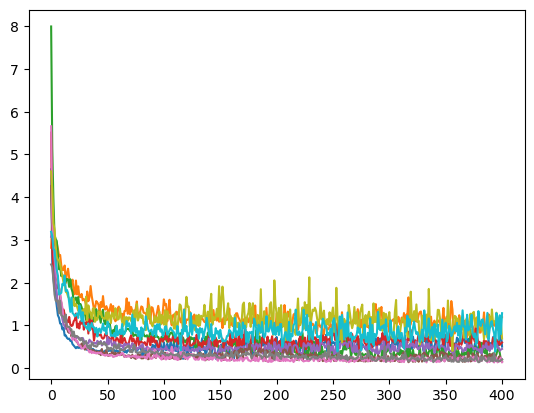

In [132]:
hl = np.sum(np.mean(kl_mat, axis=1), axis=2)
for k in range(0,10):
    plt.plot(hl[:,k])

In [19]:
h_mat = vfun(reg_prob)
ave_h = np.mean(h_mat, axis=(2,3))

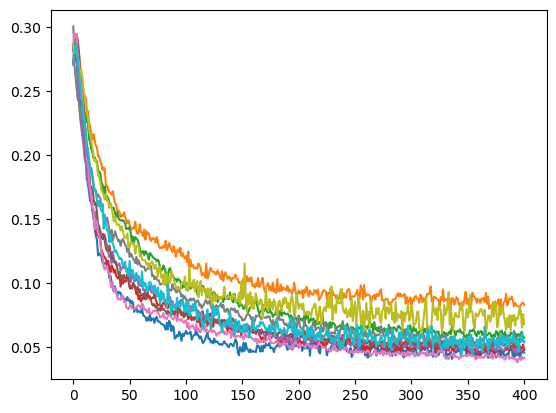

In [20]:
for k in range(0,10):
    plt.plot(ave_h[:,k])

In [21]:
reg_prob = np.mean(reg_prob, axis=2)

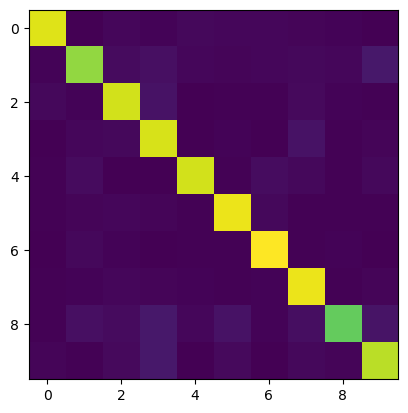

In [22]:
plt.imshow(reg_prob[300])

In [23]:
#Calculate entropy
H_mat = np.sum(vfun(reg_prob*np.eye(10,10)), axis=2)
H_mean = np.mean(H_mat, axis=1)

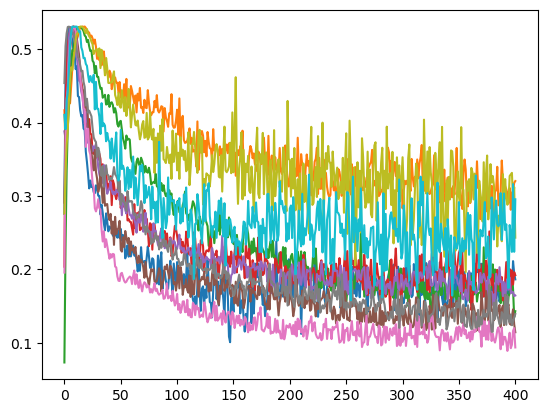

In [24]:
for k in range(0,10):
    plt.plot(H_mat[:,k])

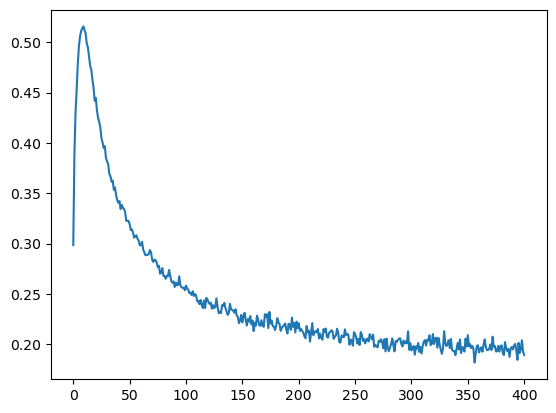

In [25]:
plt.plot(H_mean)

In [26]:
entropy_mat = -np.mean(np.log2(reg_prob)*reg_prob, axis=2)
entropy_list = np.mean(entropy_mat, axis=1)

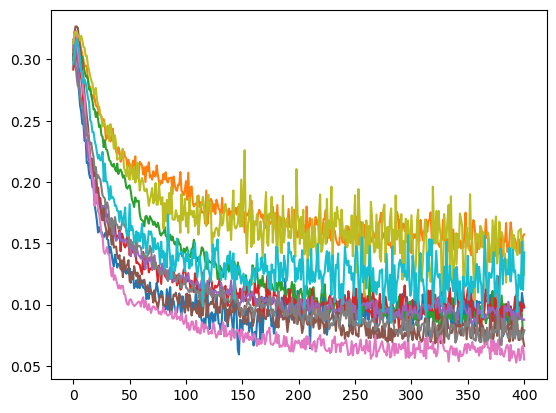

In [27]:
for k in range(0,10):
    plt.plot(entropy_mat[:,k])

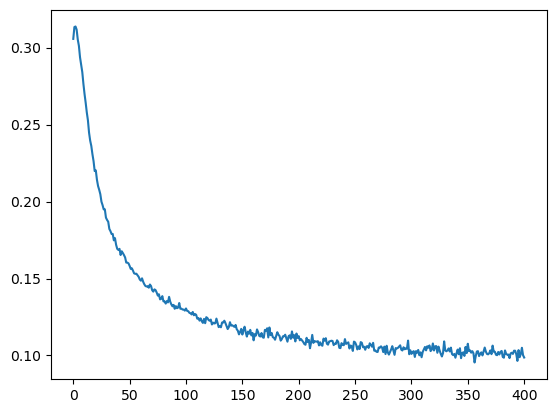

In [28]:
plt.plot(entropy_list)

#Entropy for actuall output

In [29]:
res = np.transpose(np.argmax(prob_mat_list,axis=-1), [0,2,1])
output = np.tensordot(np.ones(res.shape[0:-1]), np.arange(0,10),0) == res

In [30]:
output_mat = np.zeros([401,10,10])

for k in range(0,10):
    output_mat[:,:,k] = np.sum(res==k*np.ones(res.shape), axis=1)/70

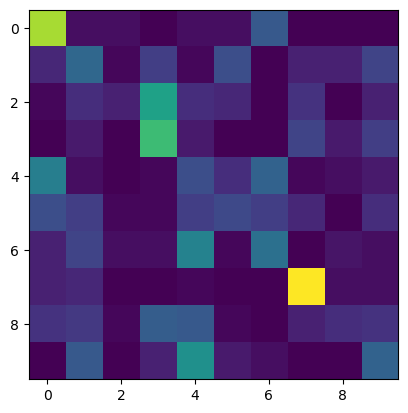

In [31]:
plt.imshow(output_mat[2])

In [32]:
#Calculate entropy
Inf_H_mat = np.sum(vfun(reg_prob*np.eye(10,10)), axis=2)
Inf_H_mean = np.mean(H_mat, axis=1)

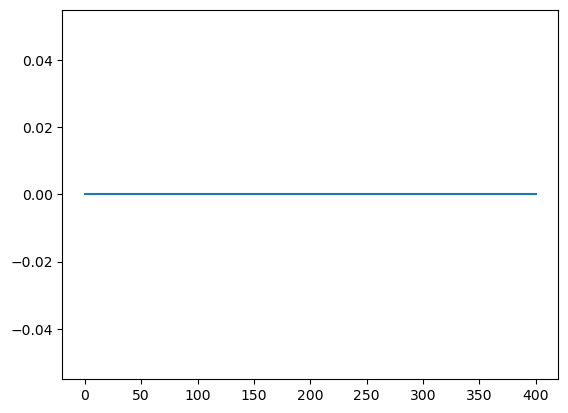

In [33]:
plt.plot(H_mean-Inf_H_mean)

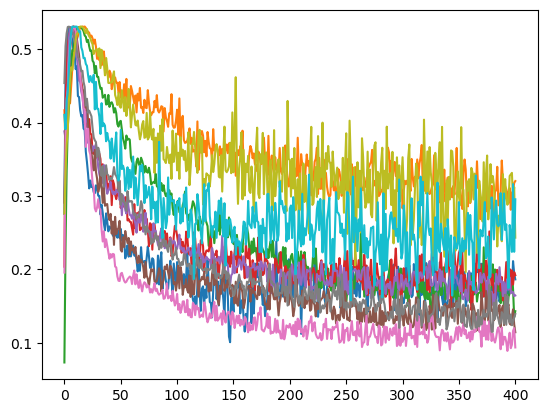

In [34]:
for k in range(0,10):
    plt.plot(Inf_H_mat[:,k])

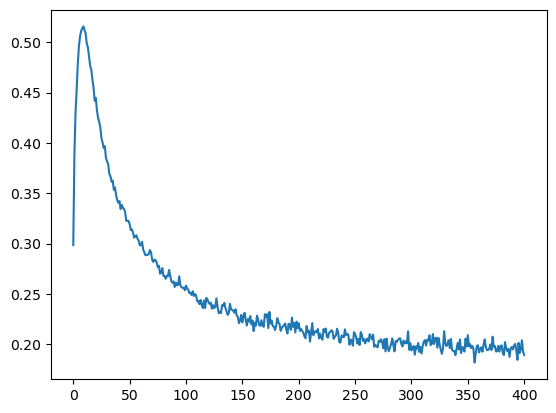

In [35]:
plt.plot(H_mean)

In [36]:
res.shape

(401, 70, 10)